In [1]:
# import internal files
from historymatch import emulators
from historymatch import sample
from historymatch import historymatch
from historymatch import plot
from historymatch import utils


# import external modules
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
import pandas as pd
#import importlib
from matplotlib.patches import Rectangle

import sklearn.linear_model as skl

plt.rcParams.update({'font.size': 10})

np.random.seed(4)

In [2]:
# import data

with open("data/MassEval2016.dat",'r') as infile:
    Masses = pd.read_fwf(infile, usecols=(2,3,4,6,11,12),
              names=('N', 'Z', 'A', 'Element', 'Ebinding', 'E_unc'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=64,
              index_col=False)
    
# Extrapolated values are indicated by '#' in place of the decimal place, so
# the Ebinding column won't be numeric. Coerce to float and drop these entries.
Masses['Ebinding'] = pd.to_numeric(Masses['Ebinding'], errors='coerce')
Masses = Masses.dropna()
Masses['E_unc'] = pd.to_numeric(Masses['E_unc'], errors='coerce')
Masses = Masses.dropna()
# Convert from keV to MeV.
Masses['Ebinding'] /= 1000
Masses['E_unc'] /= 1000

# Group the DataFrame by nucleon number, A.
Masses = Masses.groupby('A')
# Find the rows of the grouped DataFrame with the maximum binding energy.
Masses = Masses.apply(lambda t: t[t.Ebinding==t.Ebinding.max()])

A = Masses['A'].to_numpy()
Z = Masses['Z'].to_numpy()
N = Masses['N'].to_numpy()
Element = Masses['Element'].to_numpy()
Energies = Masses['Ebinding'].to_numpy()

#Energies_unc = Masses['E_unc'].to_numpy()
Energies_unc = Masses['E_unc'].to_numpy()

In [3]:
def unscale(val, mini, maxi):
        return ((val + 1)*(maxi - mini)*0.5) + mini

In [4]:
# define parameter space

'''
# hypercube
theta_0_bound = np.array([1, 7]).reshape(1,-1)
theta_1_bound = np.array([-0.4, -0]).reshape(1,-1)
theta_2_bound = np.array([0.3, 1.4]).reshape(1,-1)
theta_3_bound = np.array([0.00, 0.012]).reshape(1,-1) # keep
theta_4_bound = np.array([0.15, 0.5]).reshape(1,-1)
theta_5_bound = np.array([-0.2, 0.2]).reshape(1,-1)
'''

theta_0_bound = np.array([-1, 1]).reshape(1,-1)
theta_1_bound = np.array([-1, 1]).reshape(1,-1)
theta_2_bound = np.array([-1, 1]).reshape(1,-1)



a0_lim = np.array([-10,10]).reshape(1,-1)
a1_lim = np.array([-1, 1]).reshape(1,-1)
a2_lim = np.array([-1, 3]).reshape(1,-1)


#[ 6.89588377 -0.04145581  0.27297018]

a_limits = np.concatenate((a0_lim, a1_lim, \
                            a2_lim), axis=0)

parameter_bounds = np.concatenate((theta_0_bound, theta_1_bound, \
                                   theta_2_bound), axis=0)

#parameter_bounds = np.concatenate((theta_0_bound, theta_1_bound, theta_2_bound), axis=0)



theta_0_vals = np.linspace(a_limits[0,0], a_limits[0,1], 100)
theta_1_vals = np.linspace(a_limits[1,0], a_limits[1,1], 100)
theta_2_vals = np.linspace(a_limits[2,0], a_limits[2,1], 100)


theta_vals = np.concatenate((theta_0_vals.reshape(1,-1), theta_1_vals.reshape(1,-1), theta_2_vals.reshape(1,-1)), axis=0)


In [5]:
def LiquidDropModel(a0, a1, a2, A, Z, N):

    
    def unscale(val, mini, maxi):
        return ((val + 1)*(maxi - mini)*0.5) + mini

    a0_lim = np.array([-10,10]).reshape(1,-1)
    a1_lim = np.array([-1, 1]).reshape(1,-1)
    a2_lim = np.array([-1, 3]).reshape(1,-1)

    a_limits = np.concatenate((a0_lim, a1_lim, \
                                a2_lim), axis=0)
    
    return unscale(a0, a_limits[0,0], a_limits[0,1]) + unscale(a1, a_limits[1,0], a_limits[1,1])*A \
                + unscale(a2, a_limits[2,0], a_limits[2,1])*(A**(2.0/3.0))


#def LiquidDropModelTrue(a0, a1, a2, a3, a4, a5, A, Z, N):
    
    #return a0 + a1*A + a2*(A**(2.0/3.0)) + a3*Z*(Z-1)*(A**(-1.0/3.0)) \
            #+ a4*((N-Z)**2)/A + a5*( (-1)**Z + (-1)**N )*(2*A**(-0.5))



#def LiquidDropModel(a0, a1, a2, a3, a4, A, Z, N):
    
    #return a0 + a1*A + a2*(A**(2.0/3.0)) + a3*Z*(Z-1)*(A**(-1.0/3.0)) \
                #+ a4*((N-Z)**2)/A





In [6]:
# generate observational data with some uncertainty

noutputs = 20

start = 251
stop = 258
step = 1

#variables = np.concatenate((A[-noutputs:].reshape(-1,1),Z[-noutputs:].reshape(-1,1),\
                            #N[-noutputs:].reshape(-1,1)), axis=1)


variables = np.concatenate((A[start:stop:step].reshape(-1,1),Z[start:stop:step].reshape(-1,1),\
                            N[start:stop:step].reshape(-1,1)), axis=1)

print(len(A[start:stop:step]))

7


In [7]:
# Now we set up the design matrix X
X = np.zeros((len(A),3))
X[:,0] = np.ones_like(A)
X[:,1] = A
X[:,2] = A**(2.0/3.0)



In [8]:

clf = skl.LinearRegression(fit_intercept=False).fit(X, Energies)

print(clf.coef_)

preds = clf.predict(X)


err = np.sum(np.square(Energies-preds))

pred_sigma = np.sqrt(err / (len(Energies) - 5 - 1)) 

#https://stats.stackexchange.com/questions/284772/estimator-of-variance-of-error
print(pred_sigma)

[ 6.89588377 -0.04145581  0.27297018]
0.1504379823324015


In [23]:
# generate observational data (for testing)

sigma_obs = Energies_unc

#https://www.int.washington.edu/users/bertsch/articles/369.pdf
sigma_model = pred_sigma

obs_data = Energies
#obs_data = np.array(LiquidDropModelTrue(*clf.coef_, *variables.T)) + Energies_unc[start:stop:step]

In [24]:
nwaves = 3
ndim = 3
volshape = 'ellipsoid'

In [25]:
#importlib.reload(historymatch)

# initialise history matching class
HM = historymatch.HistoryMatch(ndim, 'GP', volshape)

In [26]:


ToyModel = historymatch.Simulator(HM)
ToyModel.set_simulator(LiquidDropModel)

#obs_data[start:stop:step]

HM.set_observations(obs_data[start:stop:step], variables=variables, sigma_obs=sigma_obs, sigma_model=sigma_model)
HM.initialize_volume(parameter_bounds[:,0], parameter_bounds[:,1])

results = HM.run(nwaves=nwaves)

Running wave 1


100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


(20, 4)
Convergence : True
Relative nonimplausible volume remaining: 0.124
Running wave 2


100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


(16976, 4)
Convergence : True
Relative nonimplausible volume remaining: 1.217
Running wave 3


100%|██████████| 7/7 [00:01<00:00,  6.73it/s]

(18727, 4)
Convergence : True
Relative nonimplausible volume remaining: 1.186


In [27]:
plot_wave = 1


In [28]:
#importlib.reload(plot)

#fig, axes = plt.subplots(ndim,ndim,figsize=(10,10))

#plot.plotcorner(results.I_samples[4], parameter_bounds, ndim, bins=20, Fig=(fig,axes), labels=('a0', 'a1', 'a2', 'a3', 'a4', 'a5'))
#axes[1,0].scatter(clf.coef_[0],clf.coef_[1], color='red')
#axes[2,0].scatter(clf.coef_[0],clf.coef_[2], color='red')
#axes[2,1].scatter(clf.coef_[1],clf.coef_[2], color='red')
#axes[3,1].scatter(clf.coef_[1],clf.coef_[3], color='red')
#axes[2,3].scatter(clf.coef_[3],clf.coef_[2], color='red')

#for i in range(ndim):
    #axes[i,i].axvline(clf.coef_[i], color='red')

In [29]:
#analytic_mean = np.loadtxt("data/LD_analytic_mean.txt").reshape(ndim,)
#analytic_cov = np.loadtxt("data/LD_analytic_cov.txt").reshape(ndim,ndim)

#print(analytic_cov)

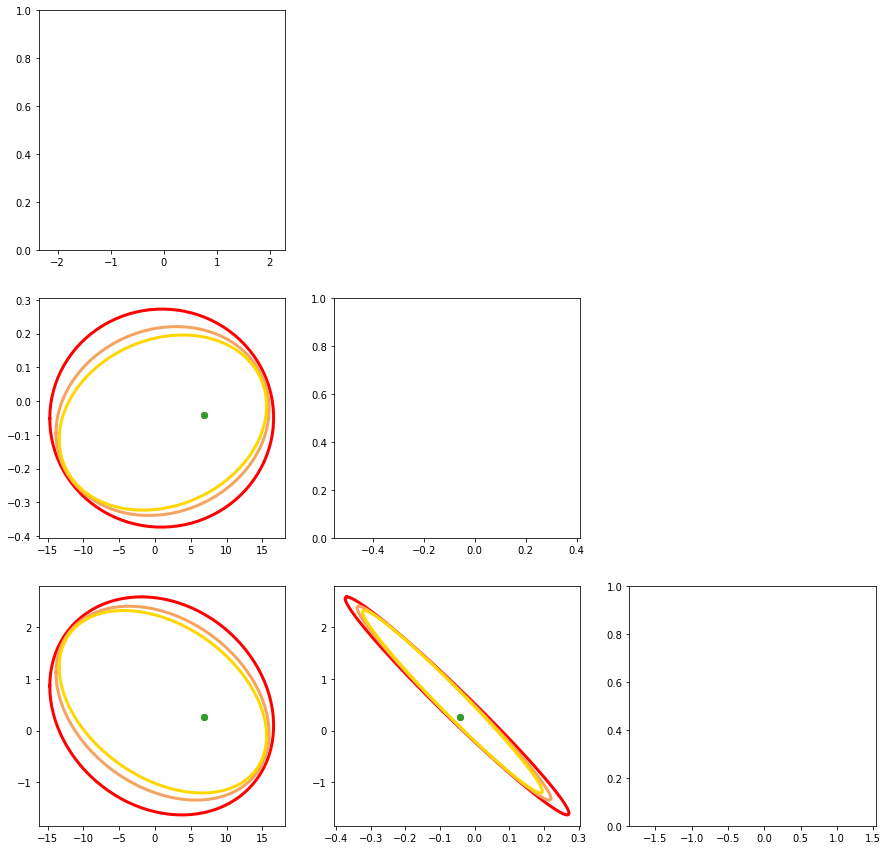

In [30]:
#importlib.reload(plot)

colors = ['red', 'sandybrown', 'gold', 'yellowgreen', 'mediumseagreen', 'turquoise', 'cornflowerblue', 'mediumpurple', 'plum', 'lightpink', ]
theta_names = [r'$a_{0}$', r'$a_{V}$', r'$a_{S}$', r'$a_{C}$', r'$a_{S}$', r'$a_{P}$']

sample_bounds = utils.locate_boundaries(results.samples[-1], ndim)
tempbounds = np.concatenate((sample_bounds[-1].reshape(-1,1),sample_bounds[-1].reshape(-1,1)),axis=1).T

true = clf.coef_
#true = [15.92808016, -18.53454643,  -0.72795844, -23.73239355,]

fig, axes = plt.subplots(ndim, ndim, figsize=(15,15))
if volshape == 'ellipsoid':
    for k in range(nwaves):
        
        nonimplausible_scaled = np.zeros_like(results.nonimplausible[k])
        for dim in range(ndim):
            nonimplausible_scaled[:,dim] = unscale(results.nonimplausible[k][:,dim], a_limits[dim,0],  a_limits[dim,1])
        mean = np.mean(nonimplausible_scaled[:,:-1].T, axis=1)
        cov = np.cov(nonimplausible_scaled[:,:-1].T)
        
        for i in range(ndim):
            for j in range(ndim):
                ax = axes[j,i]
                if i < j:
                    #true_cov = np.array([[analytic_cov[i,i], analytic_cov[i,j]],[analytic_cov[j,i], analytic_cov[j,j]]])
                    cov_matrix = np.array([[cov[i,i], cov[i,j]],[cov[j,i], cov[j,j]]])
                    plot.get_cov_ellipse(cov_matrix, [mean[i],mean[j]], 3, 5.991, ax, colors[k])
                    #plot.get_cov_ellipse(true_cov, [analytic_mean[i],analytic_mean[j]], 3, 5.991, ax, 'black')
                    #ax.set_xlim([parameter_bounds[i][0],parameter_bounds[i][1]])
                    #ax.set_ylim([parameter_bounds[j][0],parameter_bounds[j][1]])
                    ax.scatter(true[i],true[j])
                elif i == j:
                    #ax.plot(theta_vals[i], stats.norm.pdf(theta_vals[i], mean[i], np.sqrt(cov[i,i])), color='plum')
                    ax.set_xlim([sample_bounds[i][0],sample_bounds[i][1]])
                    #ax.set_title(str(theta_names[i]) + '=' + str(round(theta_best[i], 2)), fontsize=14)
                else:
                    ax.axis('off')
elif volshape == 'hypercube':
    for p in range(nwaves):
        k = -1
        
        nonimplausible_scaled = np.zeros_like(results.nonimp_bounds[k])
        print(results.nonimp_bounds[k].shape)
        for dim in range(ndim):
            nonimplausible_scaled[dim] = unscale(results.nonimp_bounds[k][dim], a_limits[dim,0],  a_limits[dim,1])
            
        for i in range(ndim):
            for j in range(ndim):
                ax = axes[j,i]
                if i < j:
                    #true_cov = np.array([[analytic_cov[i,i], analytic_cov[i,j]],[analytic_cov[j,i], analytic_cov[j,j]]])
                    ax.add_patch(Rectangle((nonimplausible_scaled[i,0], nonimplausible_scaled[j,0]),\
                                           (nonimplausible_scaled[i,1]-nonimplausible_scaled[i,0]), \
                                           (nonimplausible_scaled[j,1]-nonimplausible_scaled[j,0]),\
                        color=colors[k],alpha=0.7,label='Nonimp. Hypercube'))
                    #plot.get_cov_ellipse(true_cov, [analytic_mean[i],analytic_mean[j]], 3, 5.991, ax, 'black')
                    ax.set_xlim([a_limits[i][0],a_limits[i][1]])
                    ax.set_ylim([a_limits[j][0],a_limits[j][1]])
                    ax.scatter(true[i],true[j])
                    ax.set_xlabel(theta_names[i])
                    ax.set_ylabel(theta_names[j])
                else:
                    ax.axis('off')

                    

[-8.99527611  2.97084771 -6.51512793 ...  5.7017174  -6.24677919
 -0.15787186]


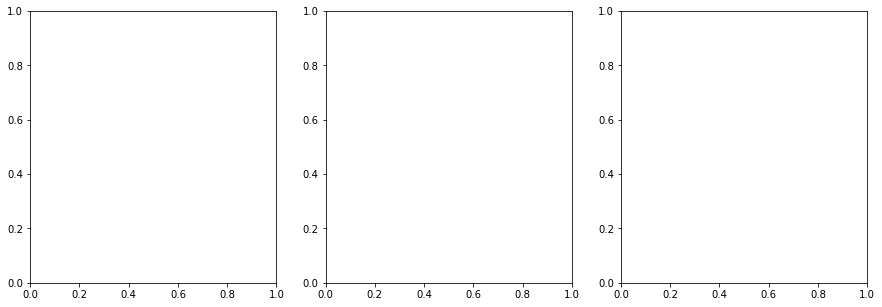

In [31]:
fig, axes = plt.subplots(1,3,figsize=(15,5))

theta_names = [r'$a_{0}$', r'$a_{V}$', r'$a_{S}$', r'$a_{C}$', r'$a_{S}$', r'$a_{P}$']
#col2 = np.where(results.I_samples[1][:,-1]<3,'g','r')
col = 'red'



nonimplausible_scaled = np.zeros_like(results.nonimplausible[1])
samples_scaled = np.zeros_like(results.samples[1])
for dim in range(ndim):
    nonimplausible_scaled[:,dim] = unscale(results.nonimplausible[1][:,dim], a_limits[dim,0],  a_limits[dim,1])
    samples_scaled[:,dim] = unscale(results.samples[1][:,dim], a_limits[dim,0],  a_limits[dim,1])

k=0
print(nonimplausible_scaled[:,0])
    
#for i in np.arange(0,6,2):
    #axes[k].scatter(samples_scaled[:,i], samples_scaled[:,i+1], s=2, color='gold',alpha=0.5, label='Samples')
    #axes[k].scatter(nonimplausible_scaled[:,i], nonimplausible_scaled[:,i+1], s=20, color='red', label='Nonimplausible Samples')
    #axes[k].set_xlabel(theta_names[i])
    #axes[k].set_ylabel(theta_names[i+1])
    #k += 1

#fig.suptitle('Wave 1 Nonimplausible Samples (20,000 Samples)')
#plt.savefig('figures/wave1_pts.png', bbox_inches='tight', facecolor='white', transparent=False)


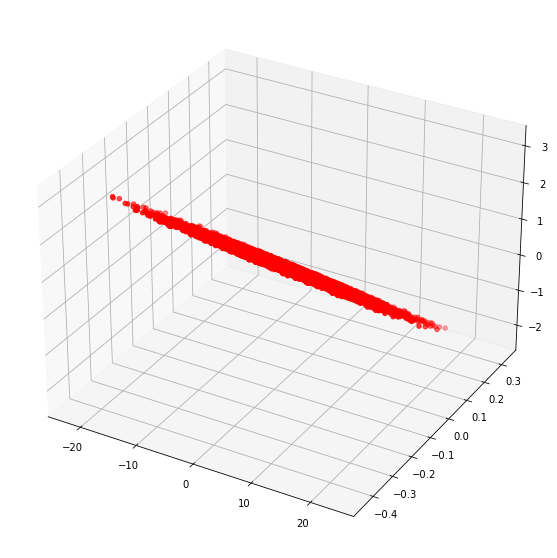

In [32]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

ax.scatter(nonimplausible_scaled[:,0], nonimplausible_scaled[:,1], nonimplausible_scaled[:,2], s=20, color='red', label='Nonimplausible Samples')



In [33]:
print(results.samples[0])
print(results.samples[1])

[[-0.68775 -0.32905 -0.09715]
 [-0.85225 -0.13115 -0.36095]
 [ 0.75625 -0.52675 -0.69845]
 ...
 [ 0.18155 -0.81985  0.85245]
 [ 0.14995  0.03515  0.51105]
 [-0.27795  0.20395 -0.38945]]
[[-0.89952761  0.11745695 -0.68101783]
 [ 0.29708477 -0.16670596  0.09033799]
 [-0.65151279 -0.01954558 -0.27232688]
 ...
 [-0.62467792  0.02834848 -0.4294251 ]
 [-0.01578719  0.00577468 -0.42627343]
 [-0.35438846  0.19992933 -1.01485427]]


NameError: name 'analytic_mean' is not defined

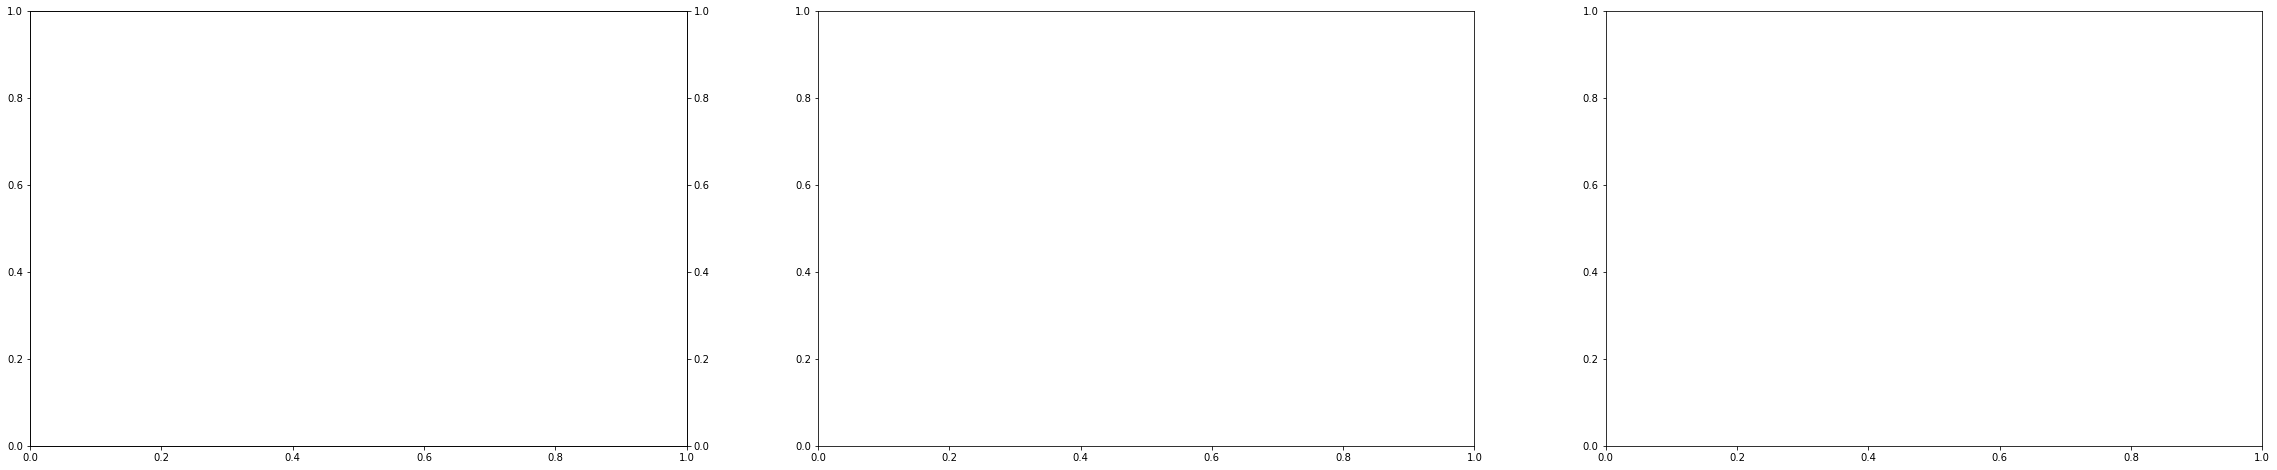

In [20]:
fig, axes = plt.subplots(1,ndim,figsize=(40,8))
theta_names = [r'$a_{0}$', r'$a_{V}$', r'$a_{S}$', r'$a_{C}$', r'$a_{S}$', r'$a_{P}$']
#ax1_right = ax1.twinx()

for i in range(ndim):
    
    nonimplausible_scaled = np.zeros_like(results.nonimplausible[-1])
    nonimplausible_scaled[:,i] = unscale(results.nonimplausible[-1][:,i], a_limits[i,0],  a_limits[i,1])
            
    ax_right = axes[i].twinx()
    #plot.opticaldepth_1D(final_wave_HC, parameter_bounds[i], i, bins=50, Fig=(fig, axes[i]), plot_kwargs={'color': 'lightblue'})
    ax_right.plot(theta_vals[i], stats.norm.pdf(theta_vals[i], analytic_mean[i],\
                                                np.sqrt(analytic_cov[i,i])), color='orangered', linewidth=3, label='Posterior Distribution')
    axes[i].set(yticklabels=[])  
    axes[i].tick_params(left=False)
    ax_right.set(yticklabels=[])  
    ax_right.tick_params(right=False)
    
    #for j in range(nwaves):
    
    min_a = np.min(nonimplausible_scaled[:,i].T[:-1])
    max_a = np.max(nonimplausible_scaled[:,i].T[:-1])
    axes[i].axvline(min_a, color='grey', linestyle='--', linewidth=3)
    axes[i].axvline(max_a, color='grey', linestyle='--', linewidth=3)
    
    #ax_right.axvline(max_theta1, color='cornflowerblue', linestyle='--', linewidth=3, label=r'Wave 1 Nonimplausible Vol. Limits')
    #ax_right.axvline(max_theta2, color='orange', linestyle='--', linewidth=3)
    #ax_right.axvline(max_theta3, color='grey', linestyle='--', linewidth=3, label=r'Nonimplausible Vol. Limits')
    
    #ax_right.axvline(min_theta1, color='cornflowerblue', linestyle='--', linewidth=3)
    #ax_right.axvline(min_theta2, color='orange', linestyle='--', linewidth=3)
    #ax_right.axvline(min_theta3, color='grey', linestyle='--', linewidth=3)
    
    axes[i].set_ylim([0, None])
    ax_right.set_ylim([0, None])
    #ax_right.set(yticklabels=[])
    
    
    axes[i].set_xlabel(theta_names[i], fontsize=30)
    #ax_right.tick_params(right=False)
    
    #axes[i].set_xticks([-1,-0.5,0,0.5,1]) 
    #axes[i].set_xticklabels([-1.0, -0.5, 0, 0.5, 1.0])
    
    #handles, labels = ax_right.get_legend_handles_labels()
    #patch = mpatches.Patch(color='lightblue', label='Optical Depth')
    #handles.append(patch) 
    #plt.legend(handles=handles, loc='best')
    
    
fig.suptitle('Analytical Likelihood against Wave 3 Nonimplausible Volume (Hypercube)', fontsize=40)
plt.tight_layout()

#plt.savefig('figures/wave3_HC_noem.png', bbox_inches='tight', facecolor='white', transparent=False)